# 03 ERP Offline Processing

Welcome to this tutorial on the processing of event related potentials (ERPs).
In this tutorial we will be using BCI essentials to do some offline processing of 
visual P300 BCI data. P300 is only one kind of event related potential, but it
is the most common. We will go through how to load P300 data, where the raw and 
epoched data are stored in the erp_data object, how to filter 

Note: If you have not already, you will have to install the ipykernel package to
run this notebook. You can do this from your terminal with "pip install ipykernel"

Another Note: To view interactive plots you need to install ipyml with 
"pip install ipympl"

## Loading a session of P300 ERP Data

First, lets load in our P300 example data from the appropriate XDF. Just like the previous tutorial, we will check the number of channels, channel labels, and sampling rate. 

Note that ERP data is stored as a different type of object, called ERP_data, which is an extension of the EEG_data object used in previous tutorials. This means that you can use all the same methods from previous tutorials.

In [15]:
# Import the bci_data module to load and process the data
from bci_essentials.bci_data import ERP_data

# Get the path of the file we want to open
filename = "..\\examples\\data\\p300_example.xdf"

# Initialize data object
p300_data = ERP_data()

# Load the XDF file into an EEG_data object
p300_data.load_offline_eeg_data(filename  = filename, print_output=False)

# Check that it worked by printing the channel labels and sampling rate
print("There are ", p300_data.nchannels, " channels in the data")
print("The channel labels are:", p300_data.channel_labels)
print("The sampling rate is:", p300_data.fsample)

There are  8  channels in the data
The channel labels are: ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'Oz', 'PO8']
The sampling rate is: 256.0


## Inspect the data

First, lets take a look at the EEG to see if anything stands out.

When we inspect we will use a bandpass filter from 0.5 - 40 Hz. 

0.5 Hz should be a high enough high-pass filter cutoff to remove the baseline drift from our EEG, without too much impact on the shape of our expected ERPs.

40 Hz will be a low enough low-pass filter cutoff to remove the powerline interference (60 Hz) and other high frequency noise.

We can change these later if need be.

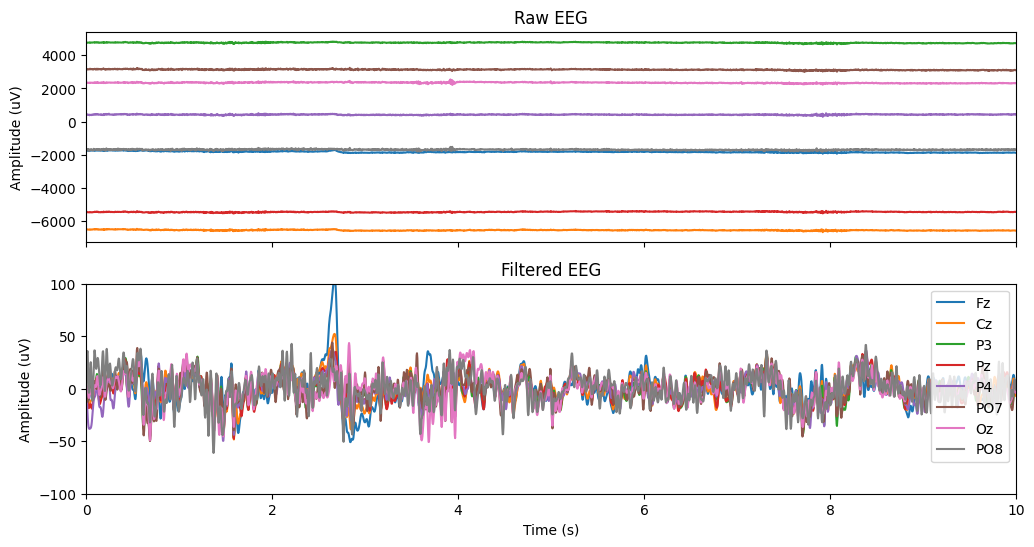

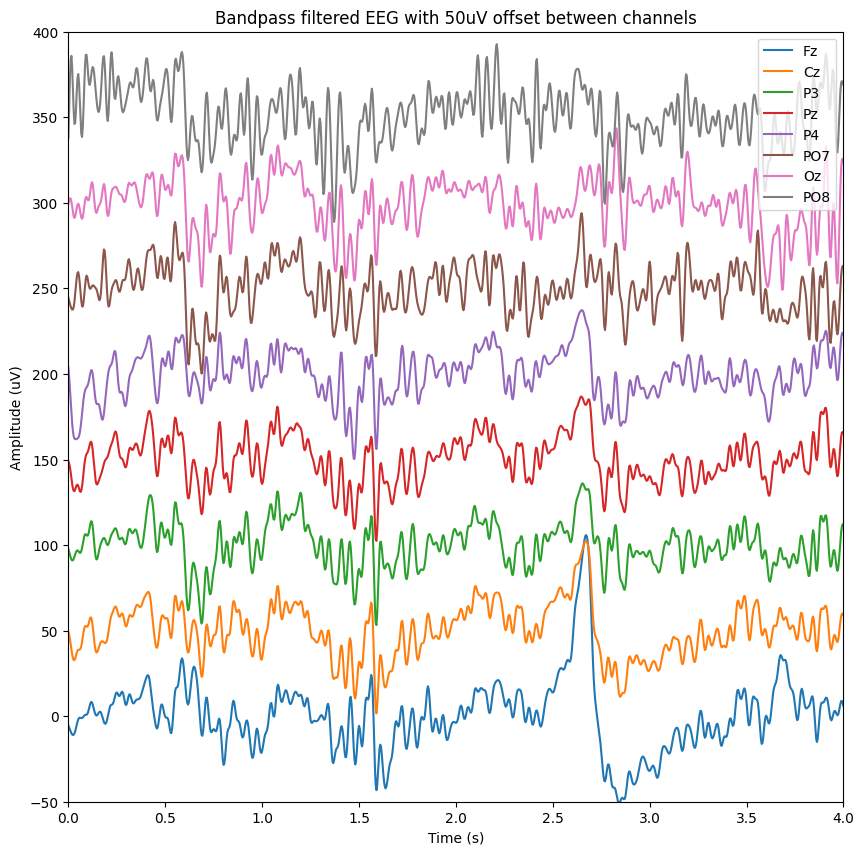

In [16]:
from bci_essentials.signal_processing import bandpass
from matplotlib import pyplot as plt
import numpy as np

raw_eeg = p300_data.eeg_data
timestamps = p300_data.eeg_timestamps - p300_data.eeg_timestamps[0]

# Bandpass filter between 1 and 40 Hz
bp_filt_eeg = bandpass(raw_eeg.T, 0.5, 30, 5, p300_data.fsample).T

# Plot the raw and filtered EEG
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax[0].plot(timestamps, raw_eeg)
ax[0].set_title('Raw EEG')
ax[0].set_ylabel('Amplitude (uV)')
ax[0].set_xlim([0, 10])
ax[1].plot(timestamps, bp_filt_eeg)
ax[1].set_title('Filtered EEG')
ax[1].set_ylabel('Amplitude (uV)')
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim([0, 10])
ax[1].set_ylim([-100, 100])
ax[1].legend(p300_data.channel_labels)
plt.show()

# Plot the bandpass_filt_eeg again but with 50uV of offset between each channel
plt.figure(figsize=(10, 10))
plt.plot(timestamps, bp_filt_eeg + np.arange(0, 50 * 8, 50))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Bandpass filtered EEG with 50uV offset between channels')
plt.xlim([0, 4])
plt.ylim([-50, 400])
plt.legend(p300_data.channel_labels)
plt.show()


## ERP Markers

Let's look at the marker data included with this 

In [17]:
# Print the first 5 markers
print('The first 5 markers are:', p300_data.marker_data[:10])

# The timestamps of those markers are:
print('The timestamps of those markers are:', p300_data.marker_timestamps[:10] - p300_data.eeg_timestamps[0])

The first 5 markers are: [['Trial Started'], ['p300,s,9,8,0'], ['p300,s,9,8,4'], ['p300,s,9,8,7'], ['p300,s,9,8,2'], ['p300,s,9,8,1'], ['p300,s,9,8,5'], ['p300,s,9,8,6'], ['p300,s,9,8,3'], ['p300,s,9,8,8']]
The timestamps of those markers are: [8.24437793 8.24745043 8.44386673 8.64410173 8.82857743 9.01289643
 9.19756073 9.38272063 9.56656253 9.76672603]


Hmmmm a little bit cryptic. Here is a guide.

'p300, ['s' for singleflash OR 'm' for multiflash], [number of selectable objects], [the selection target], [the target(s) flashing at this moment]'

Lets plot a section of EEG, but lets add vertical lines that denote the time the stimuli occured. Blue will be used to denote a time of a non-target stimulus, red will denote the flashing of the target stimulus, and the dashed red line will denote the the time 300ms after the target stimulus, approximately where we expect to see our characteristic P300 response.

Try changing the xlim values and replotting to see if you can find a prominent P300 response.

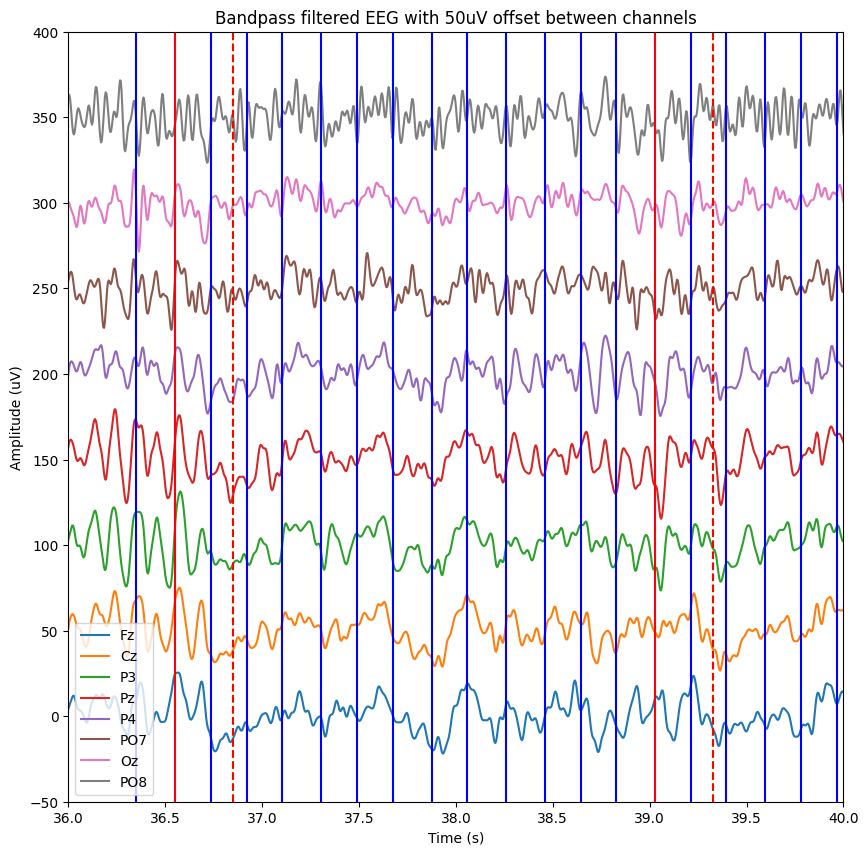

In [18]:
# Plot the bandpass_filt_eeg again but with 50uV of offset between each channel
plt.figure(figsize=(10, 10))
plt.plot(timestamps, bp_filt_eeg + np.arange(0, 50 * 8, 50))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Bandpass filtered EEG with 50uV offset between channels')
plt.xlim([36, 40])
plt.ylim([-50, 400])
plt.legend(p300_data.channel_labels)


# For all the markers in the data, find the ones that are 'Target' markers, by seeing if the last two integers in the string match
markers = p300_data.marker_data

# Initialize a list to store the target indices and non target indices
target_indices = []
non_target_indices = []


for i, marker in enumerate(markers):
    try:
        marker_target = int(marker[0][-3])
        marker_label = int(marker[0][-1])

        if marker_target == marker_label:
            target_indices.append(i)

            # Add a red vertical line to the plot at the time of the target marker
            plt.axvline(p300_data.marker_timestamps[i] - p300_data.eeg_timestamps[0], color='r')

            # Add a dotted red vertical line 300ms after the target marker
            plt.axvline(p300_data.marker_timestamps[i] - p300_data.eeg_timestamps[0] + 0.3, color='r', linestyle='--')

        else :
            non_target_indices.append(i)

            # Add a blue vertical line to the plot at the time of the non-target marker
            plt.axvline(p300_data.marker_timestamps[i] - p300_data.eeg_timestamps[0], color='b')


    except:
        continue


plt.show()

How did it go, did you find a characteristic P300 response? 

...

Me neither! Although it looks like there could be a slight negative deflection around the 300ms marks.

This is because the signal to noise (SNR) of even a relatively large effect, like the P300, is still very small.

Luckily, there is a tool we can use to better capture the P300. It is called ensemble averaging.

Ensemble averaging takes many time synchronized epochs of EEG and averages them together. Because noise is assumed to be random, it should average to zero, leaving only our expected signal.

Lets try and see what the average target response looks like for this data, compared to the average non target response.



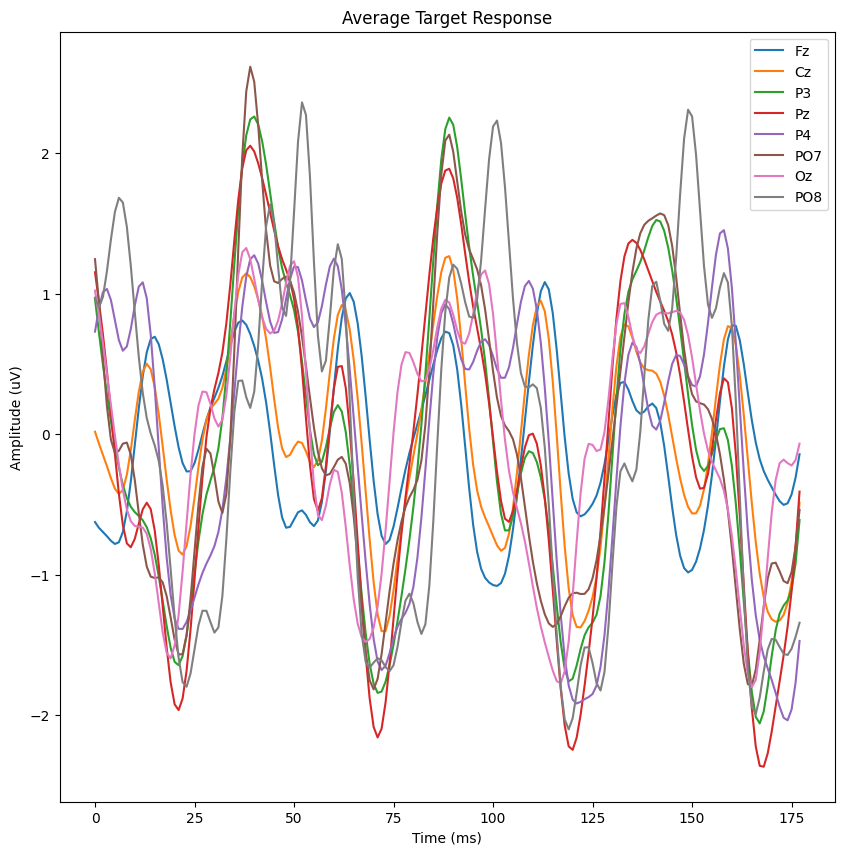

In [33]:
# Target response

# For each target index, collect the eeg data from -100ms to 600ms after the target marker
# Initialize an empty array to store the target epochs
target_epochs = np.zeros((int(0.7 * p300_data.fsample - 1), p300_data.nchannels, len(target_indices)))
for i, target_index in enumerate(target_indices):
    target_timestamp = p300_data.marker_timestamps[i]

    # Find the nearest index of the timestamp in the eeg data
    target_index = np.argmin(np.abs(p300_data.eeg_timestamps - target_timestamp))
    epoch_start_index = target_index - int(0.1 * p300_data.fsample)
    epoch_end_index = target_index + int(0.6 * p300_data.fsample)

    # Collect the eeg data from -100ms to 600ms after the target marker
    target_epochs[:, :, i] = bp_filt_eeg[epoch_start_index:epoch_end_index, :]

average_target_epochs = np.mean(target_epochs, axis=2)

# Plot the average target response
plt.figure(figsize=(10, 10))
plt.plot(average_target_epochs)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (uV)')
plt.title('Average Target Response')
plt.legend(p300_data.channel_labels)
plt.show()




## Exploring ERP data

So what is different about EEG_data and ERP_data?

The primary different is the presence of an additional field